In [1]:
import random
import time
import turtle
import math
import numpy as np

from deap import base
from deap import creator
from deap import tools

import os
import pickle

import matplotlib.pyplot as plt

In [2]:
XSIZE = YSIZE = 16 # Number of grid cells in each direction (do not change this)

HEADLESS = True

In [3]:
class DisplayGame:
    def __init__(self, XSIZE, YSIZE):
        # SCREEN
        self.win = turtle.Screen()
        self.win.title("EVCO Snake game")
        self.win.bgcolor("grey")
        self.win.setup(width=(XSIZE * 20) + 40, height=(YSIZE * 20) + 40)
     
        self.win.tracer(0)

        # Snake Head
        self.head = turtle.Turtle()
        self.head.shape("square")
        self.head.color("black")

        # Snake food
        self.food = turtle.Turtle()
        self.food.shape("circle")
        self.food.color("yellow")
        self.food.penup()
        self.food.shapesize(0.55, 0.55)
        self.segments = []

    def reset(self, snake):
        self.segments = []
        self.head.penup()
        self.food.goto(-500, -500)
        self.head.goto(-500, -500)
        for i in range(len(snake) - 1):
            self.add_snake_segment()
        self.update_segment_positions(snake)

    def update_food(self, new_food):
        self.food.goto(((new_food[1] - 9) * 20) + 20, (((9 - new_food[0]) * 20) - 10) - 20)

    def update_segment_positions(self, snake):
        self.head.goto(((snake[0][1] - 9) * 20) + 20, (((9 - snake[0][0]) * 20) - 10) - 20)
        for i in range(len(self.segments)):
            self.segments[i].goto(((snake[i + 1][1] - 9) * 20) + 20, (((9 - snake[i + 1][0]) * 20) - 10) - 20)

    def add_snake_segment(self):
        self.new_segment = turtle.Turtle()
        self.new_segment.speed(0)
        self.new_segment.shape("square")
        self.new_segment.color(random.choice(["green", 'black', 'red', 'blue']))
        self.new_segment.penup()
        self.segments.append(self.new_segment)

In [4]:
class snake:
    def __init__(self, _XSIZE, _YSIZE):
        self.XSIZE = _XSIZE
        self.YSIZE = _YSIZE
        self.reset()

    def reset(self):
        self.snake = [[8, 10], [8, 9], [8, 8], [8, 7], [8, 6], [8, 5], [8, 4], [8, 3], [8, 2], [8, 1],
                      [8, 0]]  # Initial snake co-ordinates [ypos,xpos]
        self.food = self.place_food()
        self.ahead = []
        self.length = len(self.snake)

        self.snake_direction = "right"

    def place_food(self):
        self.food = [random.randint(1, (YSIZE - 2)), random.randint(1, (XSIZE - 2))]
        while (self.food in self.snake):
            self.food = [random.randint(1, (YSIZE - 2)), random.randint(1, (XSIZE - 2))]
        return (self.food)

    def update_snake_position(self):
        self.snake.insert(0, [
            self.snake[0][0] + (self.snake_direction == "down" and 1) + (self.snake_direction == "up" and -1), self.snake[0][1] + (self.snake_direction == "left" and -1) + (self.snake_direction == "right" and 1)])

    def food_eaten(self):
        if self.snake[0] == self.food:  # When snake eats the food
            return True
        else:
            last = self.snake.pop()  # [1] If it does not eat the food, it moves forward and so last tail item is removed
            return False

    def snake_turns_into_self(self):
        if self.snake[0] in self.snake[1:]:
            return True
        else:
            return False

    def snake_hit_wall(self):
        if self.snake[0][0] == 0 or self.snake[0][0] == (YSIZE - 1) or self.snake[0][1] == 0 or self.snake[0][1] == (
                XSIZE - 1):
            return True
        else:
            return False

    # Sensing functions
    def check_collision(self):
        # Snake looks ahead a tile and checks if its about to collide 
        collide_left = self.snake[0][1] - 1 == 0 or [self.snake[0][0], self.snake[0][1] - 1] in self.snake
        collide_right = self.snake[0][1] + 1 == XSIZE - 1 or [self.snake[0][0], self.snake[0][1] + 1] in self.snake
        collide_up = self.snake[0][0] - 1 == 0 or [self.snake[0][0] - 1, self.snake[0][1]] in self.snake
        collide_down = self.snake[0][0] + 1 == YSIZE - 1 or [self.snake[0][0] + 1, self.snake[0][1]] in self.snake
        return collide_left, collide_right, collide_up, collide_down

    def theta_from_snake2food(self):
        #find the angle theta from the snake head to the food  
        return math.atan2(self.food[0] - self.snake[0][0], self.food[1] - self.snake[0][1])
    
    def check_snake_length(self):
        self.length = len(self.snake)
        return self.length

In [5]:
snake_game = snake(XSIZE,YSIZE)

if not HEADLESS:
    display = DisplayGame(XSIZE,YSIZE)

In [6]:
def run_game(display, AIBrain, snake_game, headless):
    
    score = 0
    step_count = 0
    
    # number of steps since the last food item was obtained by the snake
    hunger_step_distance = 0


    snake_game.reset()
    if not headless:
        display.reset(snake_game.snake)
        display.win.update()
    snake_game.place_food()
    game_over = False
    snake_direction = "right"

    while not game_over:

        #  ****YOUR AI BELOW HERE******************

        nn_output = AIBrain.feedForward([*snake_game.check_collision(),
                                            snake_game.theta_from_snake2food()
                                            ])
        next_move = np.argmax(nn_output, axis=0)

        if next_move == 0:
            new_move = "up"
        elif next_move == 1:
            new_move = "down"
        elif next_move == 2:
            new_move = "left"
        elif next_move == 3:
            new_move = "right"

        next_move = new_move
        snake_game.snake_direction = next_move

        #  ****YOUR AI ABOVE HERE******************

        snake_game.update_snake_position()

        step_count += 1
        hunger_step_distance += 1

        # Place a new food item if one has just been obtained, then update the score 
        if snake_game.food_eaten():
            snake_game.place_food()
            score += 1
            if not headless: display.add_snake_segment()
            hunger_step_distance = 0
        
        # End the game if the snake has traversed the map for too long and failed to eat food
        if hunger_step_distance > (XSIZE*YSIZE) :
            game_over = True
         
        
        # Game over if the snake runs over itself
        if snake_game.snake_turns_into_self():
            game_over = True
  

        # Game over if the snake goes through a wall
        if snake_game.snake_hit_wall():
            game_over = True
         

        # Condition to check if the snake completes the game
        if snake_game.check_snake_length() == 185: # 196 (total map size) - 11 (initial snake length)
            game_over = True
            print("You win")

        if not headless:
            display.update_food(snake_game.food)
            display.update_segment_positions(snake_game.snake)
            display.win.update()
            time.sleep(0.2)  # Change this to modify the speed the game runs at when displayed.

    if not headless: turtle.done()

    return score # Used as fitness value for GA

In [7]:
class MLP(object):
    def __init__(self, numInput, numHidden1, numHidden2, numOutput):
        self.fitness = 0
        self.numInput = numInput + 1  # Add bias node from input to hidden layer 1 only
        self.numHidden1 = numHidden1  # Feel free to adapt the code to add more biases if you wish
        self.numHidden2 = numHidden2
        self.numOutput = numOutput

        self.w_i_h1 = np.random.randn(self.numHidden1, self.numInput)
        self.w_h1_h2 = np.random.randn(self.numHidden2, self.numHidden1)
        self.w_h2_o = np.random.randn(self.numOutput, self.numHidden2)

        self.ReLU = lambda x: max(0, x)

    def softmax(self, x):
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum()

    def feedForward(self, inputs):
        inputsBias = inputs[:]
        inputsBias.insert(len(inputs), 1)  # Add bias input

        h1 = np.dot(self.w_i_h1, inputsBias)  # feed input to hidden layer 1
        h1 = [self.ReLU(x) for x in h1]  # Activate hidden layer1

        h2 = np.dot(self.w_h1_h2, h1)  # feed layer 1 to hidden layer 2
        h2 = [self.ReLU(x) for x in h2]  # Activate hidden layer 2

        output = np.dot(self.w_h2_o, h2)  # feed to output layer

        return self.softmax(output) #return output 

    def getWeightsLinear(self):
        flat_w_i_h1 = list(self.w_i_h1.flatten())
        flat_w_h1_h2 = list(self.w_h1_h2.flatten())
        flat_w_h2_o = list(self.w_h2_o.flatten())
        return (flat_w_i_h1 + flat_w_h1_h2 + flat_w_h2_o)

    def setWeightsLinear(self, Wgenome):
        numWeights_I_H1 = self.numHidden1 * self.numInput
        numWeights_H1_H2 = self.numHidden2 * self.numHidden1
        numWeights_H2_O = self.numOutput * self.numHidden2

        self.w_i_h1 = np.array(Wgenome[:numWeights_I_H1])
        self.w_i_h1 = self.w_i_h1.reshape((self.numHidden1, self.numInput))

        self.w_h1_h2 = np.array(Wgenome[numWeights_I_H1:(numWeights_H1_H2 + numWeights_I_H1)])
        self.w_h1_h2 = self.w_h1_h2.reshape((self.numHidden2, self.numHidden1))

        self.w_h2_o = np.array(Wgenome[(numWeights_H1_H2 + numWeights_I_H1):])
        self.w_h2_o = self.w_h2_o.reshape((self.numOutput, self.numHidden2))

In [8]:
numInputNodes = 5 #(4 for collision, 1 for angle to the food)

numHiddenNodes1 = 15
numHiddenNodes2 = 15
numOutputNodes = 4

IND_SIZE = ((numInputNodes + 1) * numHiddenNodes1) + (numHiddenNodes1 * numHiddenNodes2) + (numHiddenNodes2 * numOutputNodes)

In [9]:
model = MLP(numInputNodes, numHiddenNodes1, numHiddenNodes2, numOutputNodes)

In [10]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_float", random.uniform, -1.0, 1.0)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=IND_SIZE)

In [11]:
def evaluate(indiv, model):
    fitness = 0

    # Load the individual's weights into the neural network
    model.setWeightsLinear(indiv)

    # Calculate fitness averages using a counter to combat stochasticity (i.e. if food spawns in front of snake it skews data)
    fitness_counter = 0
    for _ in range(3):
        fitness_counter += run_game(display, model, snake_game, headless=HEADLESS)

    fitness = fitness_counter / 3

    return fitness,

In [12]:
toolbox.register("evaluate", evaluate)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mutate", tools.mutGaussian, mu=0.0, sigma=0.5, indpb=0.08)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [13]:
stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

In [14]:
logbook = tools.Logbook()

pop = toolbox.population(n=500)

In [15]:
fitnesses = [toolbox.evaluate(indiv, model) for indiv in pop]
for ind, fit in zip(pop, fitnesses):
    ind.fitness.values = fit

In [16]:
NGEN = 500

for g in range(NGEN):
    print("-- Generation %i --" % g)

    offspring = toolbox.select(pop, len(pop))
    offspring = list(map(toolbox.clone, offspring))

    for mutant in offspring:
        toolbox.mutate(mutant)
        del mutant.fitness.values

    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = [toolbox.evaluate(indiv, model) for indiv in invalid_ind]
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    pop[:] = offspring
    record = stats.compile(pop)


    logbook.record(gen=g, **record)
    


-- Generation 0 --
-- Generation 1 --
-- Generation 2 --
-- Generation 3 --
-- Generation 4 --


In [17]:
#data for 15 nodes at each hidden layer (done)
gen0 = logbook.select("gen")
_min0 = logbook.select("min")
_max0 = logbook.select("max")
avgs0 = logbook.select("avg")
stds0 = logbook.select("std")

In [18]:
# USED FOR DATA VISUALISATION
#data for 5 nodes at each hidden layer
#gen1 = logbook.select("gen")
#_min1 = logbook.select("min")
#_max1 = logbook.select("max")
#avgs1 = logbook.select("avg")
#stds1 = logbook.select("std")

In [19]:
# USED FOR DATA VISUALISATION
#data for 30 nodes at each hidden layer
#gen2 = logbook.select("gen")
#_min2 = logbook.select("min")
#_max2 = logbook.select("max")
#avgs2 = logbook.select("avg")
#stds2 = logbook.select("std")

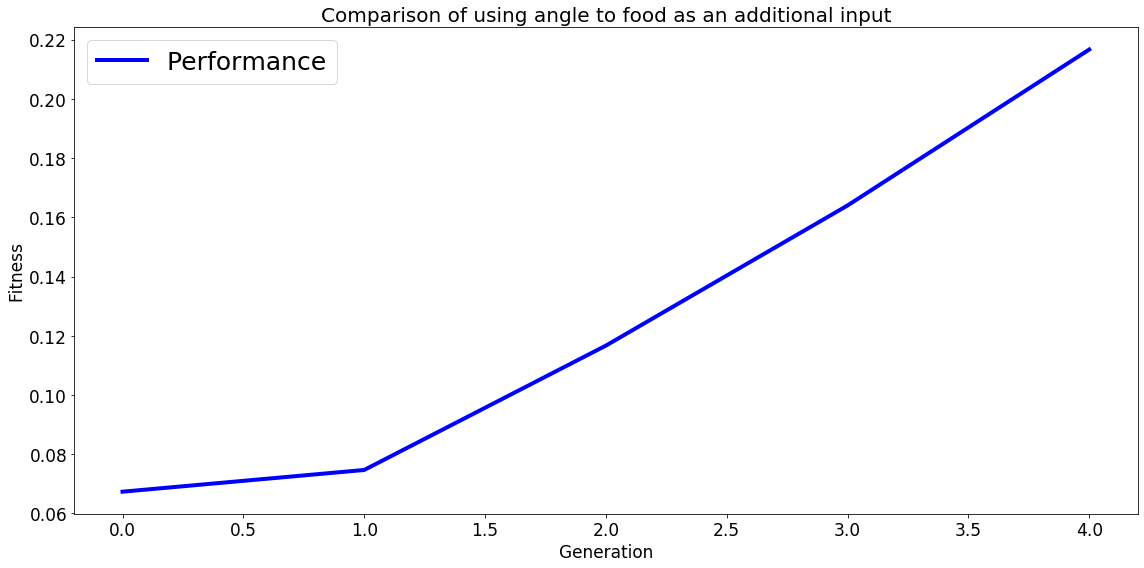

In [20]:
# Some of the data visualisation code...

plt.rc('axes', labelsize=17)
plt.rc('xtick', labelsize=17)
plt.rc('ytick', labelsize=17)
plt.rc('legend', fontsize=17)


fig=plt.figure(figsize=(16, 8))
ax = fig.subplots(1, 1)

#ax.plot(gen0, avgs0, color = "blue", label="NN 1", linewidth=4.0)
#ax.fill_between(gen0, avgs0_np+stds0_np, avgs0_np-stds0_np, facecolor='blue', alpha=0.5)

#ax.plot(gen1, avgs1, color = "red", label="Without angle", linewidth=4.0)
ax.plot(gen0, avgs0, color = "blue", label="Performance", linewidth=4.0)
#ax.fill_between(gen1, avgs1_np+stds1_np, avgs1_np-stds1_np, facecolor='red', alpha=0.5)

#ax.plot(gen1, _max1, color = "green", label="max", linewidth=4.0)

#ax.plot(gen2, avgs2, color = "green", label="NN 3", linewidth=4.0)
#ax.fill_between(gen2, avgs2_np+stds2_np, avgs2_np-stds2_np, facecolor='purple', alpha=0.5)

ax.set_xlabel("Generation")
ax.set_ylabel("Fitness")
#ax.legend(loc="upper left", prop={'size': 25})
plt.title("Comparison of using angle to food as an additional input", fontsize=20)

plt.tight_layout()

In [21]:
# Test results and save model
bestInd = tools.selBest(pop, 1)[0]
model.setWeightsLinear(bestInd)

# Run the model 5 times to remove stochasticity
i = 0
for _ in range(5):
    i += run_game(display, model, snake_game, headless=True)

print(f"Average Score: {i/5}")

Average Score: 0.2
